In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds

seed = 42
keras.utils.set_random_seed(seed)
AUTO = tf.data.AUTOTUNE

In [2]:
dataset_name = "tf_flowers"
batch_size = 64
image_size = (224, 224)

(train_data, test_data), ds_info = tfds.load(
    dataset_name,
    split=["train[:90%]", "train[90%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


def dataset_to_array(dataset, image_size, num_classes):
    images, labels = [], []
    for img, lab in dataset.as_numpy_iterator():
        images.append(tf.image.resize(img, image_size).numpy())
        labels.append(tf.one_hot(lab, num_classes))
    return np.array(images), np.array(labels)


img_train, label_train = dataset_to_array(train_data, image_size, num_classes)
img_test, label_test = dataset_to_array(test_data, image_size, num_classes)

num_train_samples = len(img_train)
print(f"Number of training sample: {num_train_samples}")

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of training sample: 3303


In [3]:
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0)),
        layers.RandomContrast(factor=0.1),
    ],
)

img_train = image_augmentation(img_train).numpy()

In [4]:
def build_model(num_classes, img_size=image_size[0], top_dropout=0.3):
    """Cria um classificador baseado em MobileNetV2 pré-treinado.

    Argumentos:
        num_classes: Int, número de classes a serem usadas na camada softmax.
        img_size: Int, tamanho quadrado das imagens de entrada (o padrão é 224).
        top_dropout: Int, valor para camada de eliminação (o padrão é 0,3).
    """

    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    model = keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_tensor=x
    )

    model.trainable = False

    x= layers.GlobalAveragePooling2D(name="avh_pool")(model.output)
    x = layers.Dropout(top_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    print("Weights treináveis:", len(model.trainable_weights))
    print("Weights não treináveis:", len(model.non_trainable_weights))
    return model


def compile_and_train(
    model,
    training_data,
    training_labels,
    metrics = [keras.metrics.AUC(name="auc"), "acc"],
    optimizer = keras.optimizers.Adam(),
    patience = 5,
    epochs = 5,
):
    stopper = keras.callbacks.EarlyStopping(
        monitor = "val_auc",
        mode = "max",
        min_delta = 0,
        patience = patience,
        verbose = 1,
        restore_best_weights = True,
    )

    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = metrics)

    history = model.fit(
        x = training_data,
        y = training_labels,
        batch_size = batch_size,
        epochs = epochs,
        validation_split = 0.1,
        callbacks = [stopper],
    )
    return history

def unfreeze(model, block_name, verbose = 0):
    """Unfreeze as camadas do modelo do keras"""

    set_trainable = False

    for layer in model.layers:
        if block_name in layer.name:
            set_trainable = True
        if set_trainable and not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            if verbose == 1:
                print(layer.name, "Treinável")
        else:
            if verbose == 1:
                print(layer.name, "NÃO treinável")
    print("Weights treináveis:", len(model.trainable_weights))
    print("Weights não treináveis:", len(model.non_trainable_weights))
    return model

In [5]:
def train_model(training_data, training_labels):

    model = build_model(num_classes)

    history = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics = [keras.metrics.AUC(name="auc"), "acc"],
        optimizer = keras.optimizers.Adam(),
        patience = 3,
        epochs = 10,
    )

    model = unfreeze(model, "block_10")

    fine_tune_epochs = 20
    total_epochs = history.epoch[-1] + fine_tune_epochs

    history_fine = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics = [keras.metrics.AUC(name="auc"), "acc"],
        optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
        epochs = total_epochs,
    )

    _, _, acc = model.evaluate(img_test, label_test)
    return np.round(acc,4)

In [6]:
def train_interatively(sample_splits = [0.05, 0.1, 0.25, 0.5], iter_per_split = 5):
    train_acc = []
    sample_sizes = []

    for fraction in sample_splits:
        print(f"Fraction Split: {fraction}")
        sample_accuracy = []
        num_samples = int(num_train_samples * fraction)
        for i in range(iter_per_split):
            print(f"Rode {i+1} de {iter_per_split}: ")
            rand_idx = np.random.randint(num_train_samples, size = num_samples)
            train_img_subset = img_train[rand_idx, :]
            train_label_subset = label_train[rand_idx, :]
            accuracy = train_model(train_img_subset, train_label_subset)
            print(f"Precisão: {accuracy}")
            sample_accuracy.append(accuracy)
        train_acc.append(sample_accuracy)
        sample_sizes.append(num_samples)
    return train_acc, sample_sizes


# Running the above function produces the following outputs
train_acc = [
    [0.8202, 0.7466, 0.8011, 0.8447, 0.8229],
    [0.861, 0.8774, 0.8501, 0.8937, 0.891],
    [0.891, 0.9237, 0.8856, 0.9101, 0.891],
    [0.8937, 0.9373, 0.9128, 0.8719, 0.9128],
]

sample_sizes = [165, 330, 825, 1651]

Curve fit weights: a = 0.6445640325546265 e b = 0.04809745401144028. 
O modelo previu 3303 samples com 0.9517362117767334 de precisão


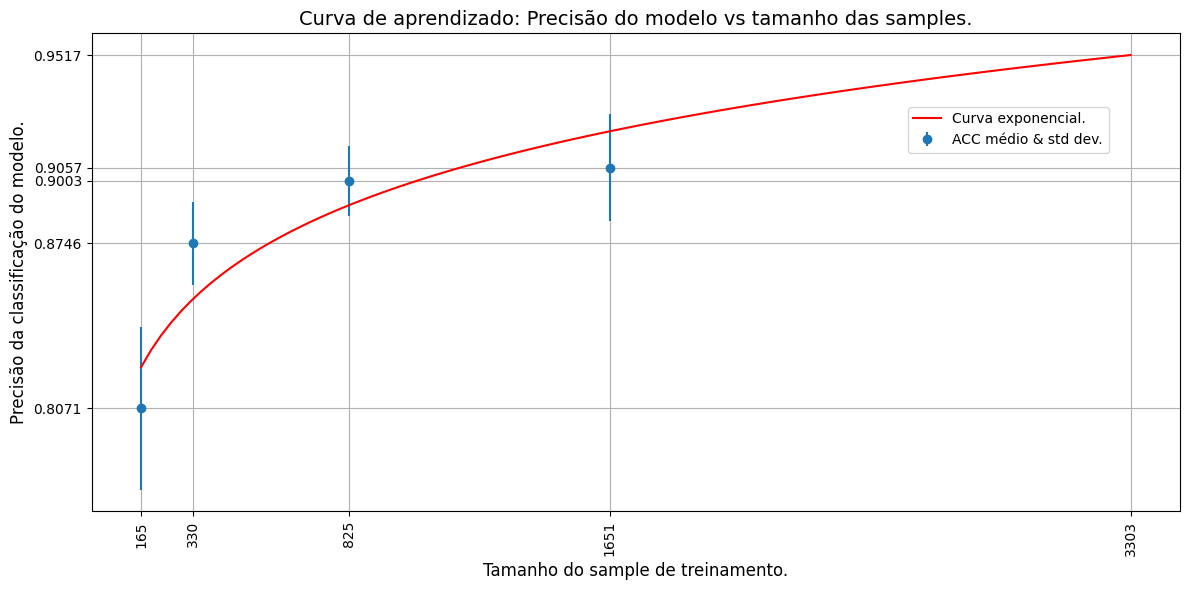

O MAE para o fit da curva é <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.016098753>>.


In [7]:
def fit_and_predict(train_acc, sample_sizes, pred_sample_size):
    x = sample_sizes
    mean_acc = tf.convert_to_tensor([np.mean(i) for i in train_acc])
    error = [np.std(i) for i in train_acc]

    mse = keras.losses.MeanSquaredError()

    def exp_func(x, a, b):
        return a * x**b

    a = tf.Variable(0.0)
    b = tf.Variable(0.0)
    learning_rate = 0.01
    training_epochs = 5000

    for epoch in range(training_epochs):
        with tf.GradientTape() as tape:
            y_pred = exp_func(x, a, b)
            cost_function = mse(y_pred, mean_acc)
        gradients = tape.gradient(cost_function, [a, b])
        a.assign_sub(gradients[0] * learning_rate)
        b.assign_sub(gradients[1] * learning_rate)
    print(f"Curve fit weights: a = {a.numpy()} e b = {b.numpy()}. ")

    max_acc = exp_func(pred_sample_size, a, b).numpy()

    print(f"O modelo previu {pred_sample_size} samples com {max_acc} de precisão")
    x_cont = np.linspace(x[0], pred_sample_size, 100)

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.errorbar(x, mean_acc, yerr=error, fmt="o", label="ACC médio & std dev.")
    ax.plot(x_cont, exp_func(x_cont, a, b), "r-", label="Curva exponencial.")
    ax.set_ylabel("Precisão da classificação do modelo.", fontsize=12)
    ax.set_xlabel("Tamanho do sample de treinamento.", fontsize=12)
    ax.set_xticks(np.append(x, pred_sample_size))
    ax.set_yticks(np.append(mean_acc, max_acc))
    ax.set_xticklabels(list(np.append(x, pred_sample_size)), rotation=90, fontsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_title("Curva de aprendizado: Precisão do modelo vs tamanho das samples.", fontsize=14)
    ax.legend(loc=(0.75, 0.75), fontsize=10)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    mae = keras.losses.MeanAbsoluteError()
    print(f"O MAE para o fit da curva é {mae(mean_acc, exp_func(x, a, b)).numpy}.")

fit_and_predict(train_acc, sample_sizes, pred_sample_size = num_train_samples)

In [8]:
accuracy = train_model(img_train, label_train)
print(f"O modelo atinge uma precisão de {accuracy} com {num_train_samples} imagens.")

<ipython-input-4-81638505f2fa>:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights treináveis: 2
Weights não treináveis: 260
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - acc: 0.4017 - auc: 0.7131 - loss: 1.4733 - val_acc: 0.7855 - val_auc: 0.9575 - val_loss: 0.5992
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - acc: 0.7845 - auc: 0.9525 - loss: 0.6153 - val_acc: 0.8429 - val_auc: 0.9760 - val_loss: 0.4526
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - acc: 0.8231 - auc: 0.9712 - loss: 0.4831 - val_acc: 0.8520 - val_auc: 0.9820 - val_loss: 0.3916
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - acc: 0.8493 - auc: 0.9780 - loss: 0.4190 - val_acc: 0.8550 - val_auc: 0.9847 - val_loss: 0.3586
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - acc: 0.8618 - auc: 0.9815 - loss: 0.3821 - val_acc: 0.8671 - val_auc: 0.9861 - val_loss: 0.3401
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - acc: 0.8816 - auc: 0.9846 - loss: 0.3503 - val_acc: 0.8761 - val_auc: 0.9875 - val_loss: 0.3235
Epoc